In [2]:
import os
import pandas as pd
import numpy as np
import cv2
from tqdm import tqdm

# ------------------------------------------
# Step 1: Setup
# ------------------------------------------
def save_emnist_digits(csv_path, output_dir, split_name, img_size=(32, 32)):
    os.makedirs(output_dir, exist_ok=True)
    print(f"🔄 Converting {split_name} digit data...")

    df = pd.read_csv(csv_path, header=None)
    labels = df.iloc[:, 0].values.astype(int)
    images = df.iloc[:, 1:].values.reshape(-1, 28, 28).astype('uint8')

    # Filter only digit classes (0–9)
    digit_indices = np.where(labels <= 9)[0]
    labels = labels[digit_indices]
    images = images[digit_indices]

    for idx, (label, image) in enumerate(tqdm(zip(labels, images), total=len(labels))):
        label_dir = os.path.join(output_dir, split_name, str(label))
        os.makedirs(label_dir, exist_ok=True)

        # ✅ FIX ORIENTATION: EMNIST images are transposed + upside-down
        image = np.transpose(image, (1, 0))  # Rotate -90
        #image = np.flip(image, axis=1)       # Flip horizontally

        # Resize to 32x32
        image = cv2.resize(image, img_size, interpolation=cv2.INTER_AREA)

        img_path = os.path.join(label_dir, f"{idx}.png")
        cv2.imwrite(img_path, image)

# ------------------------------------------
# Step 2: Convert Train/Test Digits
# ------------------------------------------
train_csv = '/kaggle/input/emnist/emnist-byclass-train.csv'
test_csv = '/kaggle/input/emnist/emnist-byclass-test.csv'
output_base = './emnist_digits_images'

save_emnist_digits(train_csv, output_base, 'train')
save_emnist_digits(test_csv, output_base, 'test')

print("✅ Digit images saved with correct orientation!")

🔄 Converting train digit data...


100%|██████████| 345035/345035 [00:46<00:00, 7360.33it/s]


🔄 Converting test digit data...


100%|██████████| 57918/57918 [00:07<00:00, 7808.50it/s]

✅ Digit images saved with correct orientation!


In [3]:
import os
import cv2
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

# ----------------------------
# Step 3: Create Validation Set from Train (15%)
# ----------------------------
print("🔧 Splitting train into train + val...")

train_dir = os.path.join(output_base, 'train')
val_dir = os.path.join(output_base, 'val')
os.makedirs(val_dir, exist_ok=True)

for digit_class in os.listdir(train_dir):
    class_path = os.path.join(train_dir, digit_class)
    if not os.path.isdir(class_path):
        continue

    images = os.listdir(class_path)
    train_imgs, val_imgs = train_test_split(images, test_size=0.15, random_state=42)

    val_class_dir = os.path.join(val_dir, digit_class)
    os.makedirs(val_class_dir, exist_ok=True)

    for img in val_imgs:
        src = os.path.join(class_path, img)
        dst = os.path.join(val_class_dir, img)
        os.rename(src, dst)

print("✅ Split completed. Train, Val, and Test sets created.")

🔧 Splitting train into train + val...
✅ Split completed. Train, Val, and Test sets created.


📷 Visualizing from Train Set Samples...


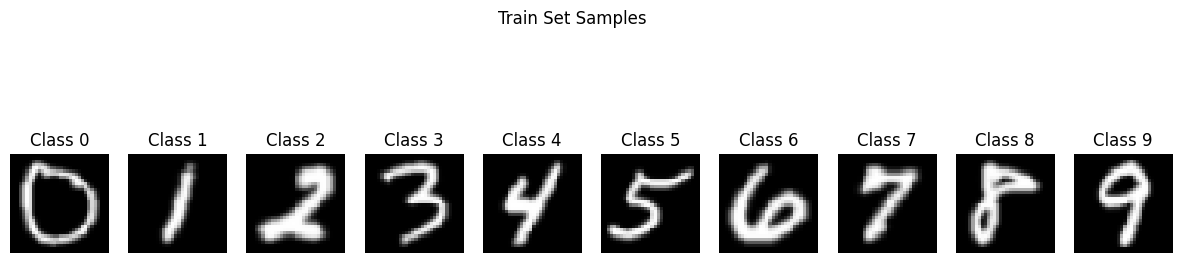

📷 Visualizing from Validation Set Samples...


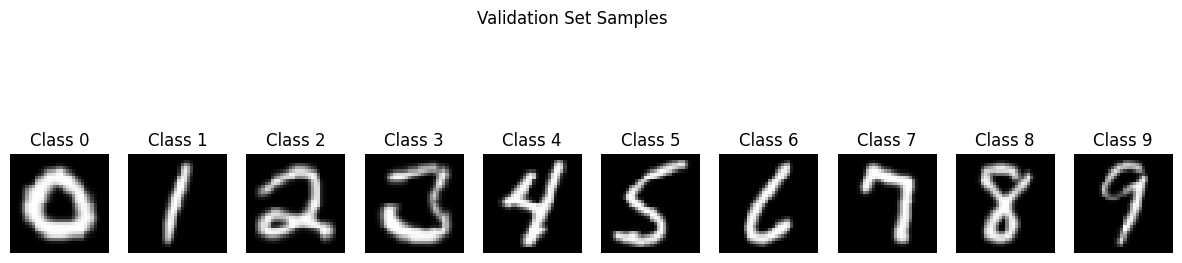

📷 Visualizing from Test Set Samples...


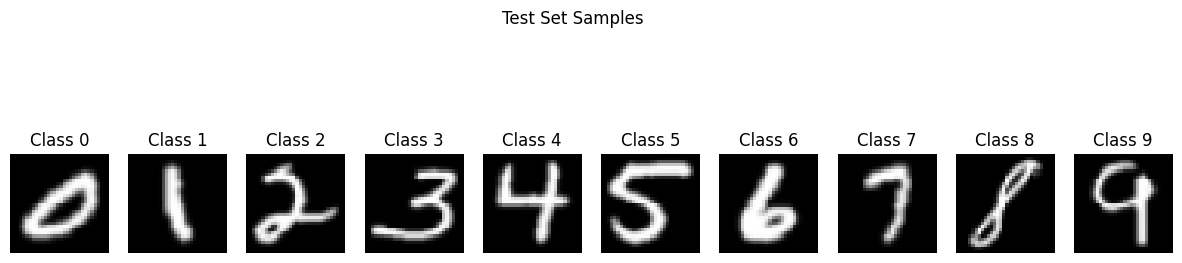

In [4]:
# ----------------------------
# Step 4: Visualize Sample Images from Each Digit Class
# ----------------------------
def visualize_samples_from_folder(folder, title, num_classes=10):
    print(f"📷 Visualizing from {title}...")
    plt.figure(figsize=(15, 4))
    shown = 0
    for i in range(num_classes):
        class_dir = os.path.join(folder, str(i))
        if not os.path.isdir(class_dir):
            continue
        images = os.listdir(class_dir)
        if not images:
            continue
        img_path = os.path.join(class_dir, images[0])
        img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
        plt.subplot(1, num_classes, shown + 1)
        plt.imshow(img, cmap='gray')
        plt.title(f"Class {i}")
        plt.axis('off')
        shown += 1
    plt.suptitle(title)
    plt.show()

visualize_samples_from_folder(os.path.join(output_base, 'train'), "Train Set Samples")
visualize_samples_from_folder(os.path.join(output_base, 'val'), "Validation Set Samples")
visualize_samples_from_folder(os.path.join(output_base, 'test'), "Test Set Samples")


In [6]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# ---------------------------------------------
# Step 2.2: Load Digit Dataset with ImageDataGenerator
# ---------------------------------------------
image_size = (32, 32)
input_shape = (32, 32, 1)
batch_size = 64
epochs = 80
num_classes = 10  # Digits 0–9

# Path where you saved the digit folders (0-9) from EMNIST
train_path = "/kaggle/working/emnist_digits_images/train"
val_path   = "/kaggle/working/emnist_digits_images/val"
test_path  = "/kaggle/working/emnist_digits_images/test"

# Augmentation for training
train_datagen = ImageDataGenerator(
    rescale=1.0/255.0,
    rotation_range=5,
    zoom_range=0.05,
    width_shift_range=0.05,
    height_shift_range=0.05,
    shear_range=0.05,
    fill_mode='nearest'
)

# No augmentation for validation and test
val_test_datagen = ImageDataGenerator(rescale=1.0/255.0)

train_generator = train_datagen.flow_from_directory(
    train_path,
    target_size=image_size,
    color_mode='grayscale',
    class_mode='sparse',  # for numerical labels
    batch_size=batch_size,
    shuffle=True,
    seed=42
)

val_generator = val_test_datagen.flow_from_directory(
    val_path,
    target_size=image_size,
    color_mode='grayscale',
    class_mode='sparse',
    batch_size=batch_size,
    shuffle=False,
    seed=42
)

test_generator = val_test_datagen.flow_from_directory(
    test_path,
    target_size=image_size,
    color_mode='grayscale',
    class_mode='sparse',
    batch_size=batch_size,
    shuffle=False,
    seed=42
)


Found 293274 images belonging to 10 classes.
Found 51761 images belonging to 10 classes.
Found 57918 images belonging to 10 classes.


In [9]:
import os
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import (Input, Conv2D, MaxPooling2D, BatchNormalization,
                                     Activation, Dropout, Flatten, Dense)
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping, ModelCheckpoint

# ----------------------------
# 1. Model Architecture: ScriptNet
# ----------------------------
def build_scriptnet(input_shape=(32, 32, 1), num_classes=10):
    inputs = Input(shape=input_shape, name='input_layer')

    # Block 1
    x = Conv2D(64, (3, 3), padding='same')(inputs)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = Conv2D(64, (3, 3), padding='same')(x)  # Extra convolution layer
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = MaxPooling2D((2, 2))(x)
    x = Dropout(0.3)(x)  # Slightly increased dropout

    # Block 2
    x = Conv2D(128, (3, 3), padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = Conv2D(128, (3, 3), padding='same')(x)  # Extra convolution layer
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = MaxPooling2D((2, 2))(x)
    x = Dropout(0.3)(x)

    # Block 3
    x = Conv2D(256, (3, 3), padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = Conv2D(256, (3, 3), padding='same')(x)  # Extra convolution layer
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = MaxPooling2D((2, 2))(x)
    x = Dropout(0.4)(x)

    # Fully connected layers
    x = Flatten()(x)
    x = Dense(1024)(x)  # Increased size
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = Dropout(0.5)(x)

    outputs = Dense(num_classes, activation='softmax', name='output_layer')(x)

    model = Model(inputs=inputs, outputs=outputs, name='ScriptNetEnhanced')
    return model

print("Model is initialized!")

Model is initialized!


In [13]:
# ----------------------------
# 3. Compile Model
# ----------------------------
model = build_scriptnet(input_shape=input_shape, num_classes=num_classes)
model.compile(optimizer=Adam(learning_rate=1e-3),
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

model.summary()

Model: "ScriptNetEnhanced"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)             │ (None, 32, 32, 1)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_12 (Conv2D)                   │ (None, 32, 32, 64)          │             640 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_14               │ (None, 32, 32, 64)          │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_14 (Activation)           │ (None, 32, 32, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_13 (Conv2D)                   │ (None, 32, 32, 64)          │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_15               │ (None, 32, 32, 64)          │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_15 (Activation)           │ (None, 32, 32, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_6 (MaxPooling2D)       │ (None, 16, 16, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_8 (Dropout)                  │ (None, 16, 16, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_14 (Conv2D)                   │ (None, 16, 16, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_16               │ (None, 16, 16, 128)         │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_16 (Activation)           │ (None, 16, 16, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_15 (Conv2D)                   │ (None, 16, 16, 128)         │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_17               │ (None, 16, 16, 128)         │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_17 (Activation)           │ (None, 16, 16, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_7 (MaxPooling2D)       │ (None, 8, 8, 128)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_9 (Dropout)                  │ (None, 8, 8, 128)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_16 (Conv2D)                   │ (None, 8, 8, 256)           │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_18               │ (None, 8, 8, 256)           │           1,024 │
│ (BatchNormalization)                 │                             │              

 Total params: 5,357,514 (20.44 MB)

 Trainable params: 5,353,674 (20.42 MB)

 Non-trainable params: 3,840 (15.00 KB)

In [14]:
# ----------------------------
# 4. Callbacks
# ----------------------------
callbacks = [
    ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=4, verbose=1),
    EarlyStopping(monitor='val_accuracy', patience=15, min_delta=0.001, restore_best_weights=True),
    ModelCheckpoint("scriptnet_EMNIST_digits_best.h5", monitor="val_accuracy", save_best_only=True, verbose=1)
]

epochs=80

# ----------------------------
# 5. Train Model
# ----------------------------
steps_per_epoch = np.ceil(train_generator.samples / batch_size).astype(int)
validation_steps = np.ceil(val_generator.samples / batch_size).astype(int)

history = model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=epochs,
    steps_per_epoch=steps_per_epoch,
    validation_steps=validation_steps,
    callbacks=callbacks,
    verbose=1
)

Epoch 1/80
4583/4583 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - accuracy: 0.9635 - loss: 0.1207
Epoch 1: val_accuracy improved from -inf to 0.99206, saving model to scriptnet_EMNIST_digits_best.h5
4583/4583 ━━━━━━━━━━━━━━━━━━━━ 177s 36ms/step - accuracy: 0.9635 - loss: 0.1207 - val_accuracy: 0.9921 - val_loss: 0.0296 - learning_rate: 0.0010
Epoch 2/80
4582/4583 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - accuracy: 0.9927 - loss: 0.0257
Epoch 3: val_accuracy improved from 0.99285 to 0.99571, saving model to scriptnet_EMNIST_digits_best.h5
4583/4583 ━━━━━━━━━━━━━━━━━━━━ 159s 35ms/step - accuracy: 0.9927 - loss: 0.0257 - val_accuracy: 0.9957 - val_loss: 0.0171 - learning_rate: 0.0010
Epoch 4/80
4582/4583 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - accuracy: 0.9938 - loss: 0.0211
Epoch 4: val_accuracy improved from 0.99571 to 0.99619, saving model to scriptnet_EMNIST_digits_best.h5
4583/4583 ━━━━━━━━━━━━━━━━━━━━ 159s 35ms/step - accuracy: 0.9938 - loss: 0.0211 - val_accuracy: 0.9962 - val_loss: 0.0160 - learning

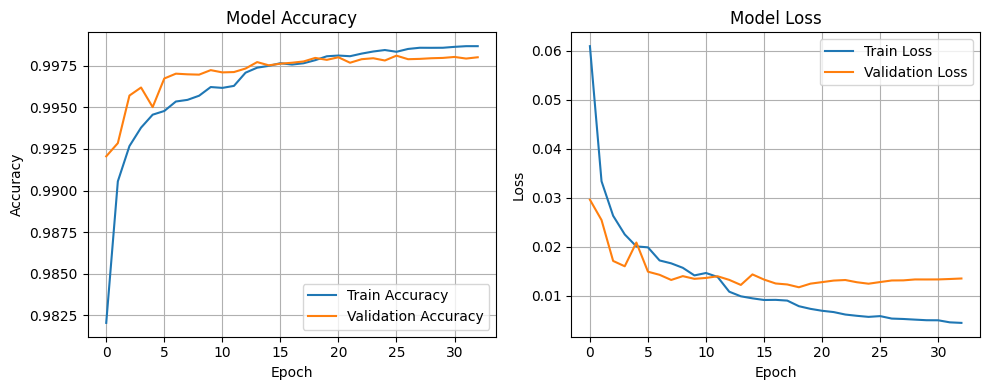

In [15]:
import matplotlib.pyplot as plt

# Plot Accuracy
plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)

# Plot Loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

905/905 ━━━━━━━━━━━━━━━━━━━━ 13s 13ms/step


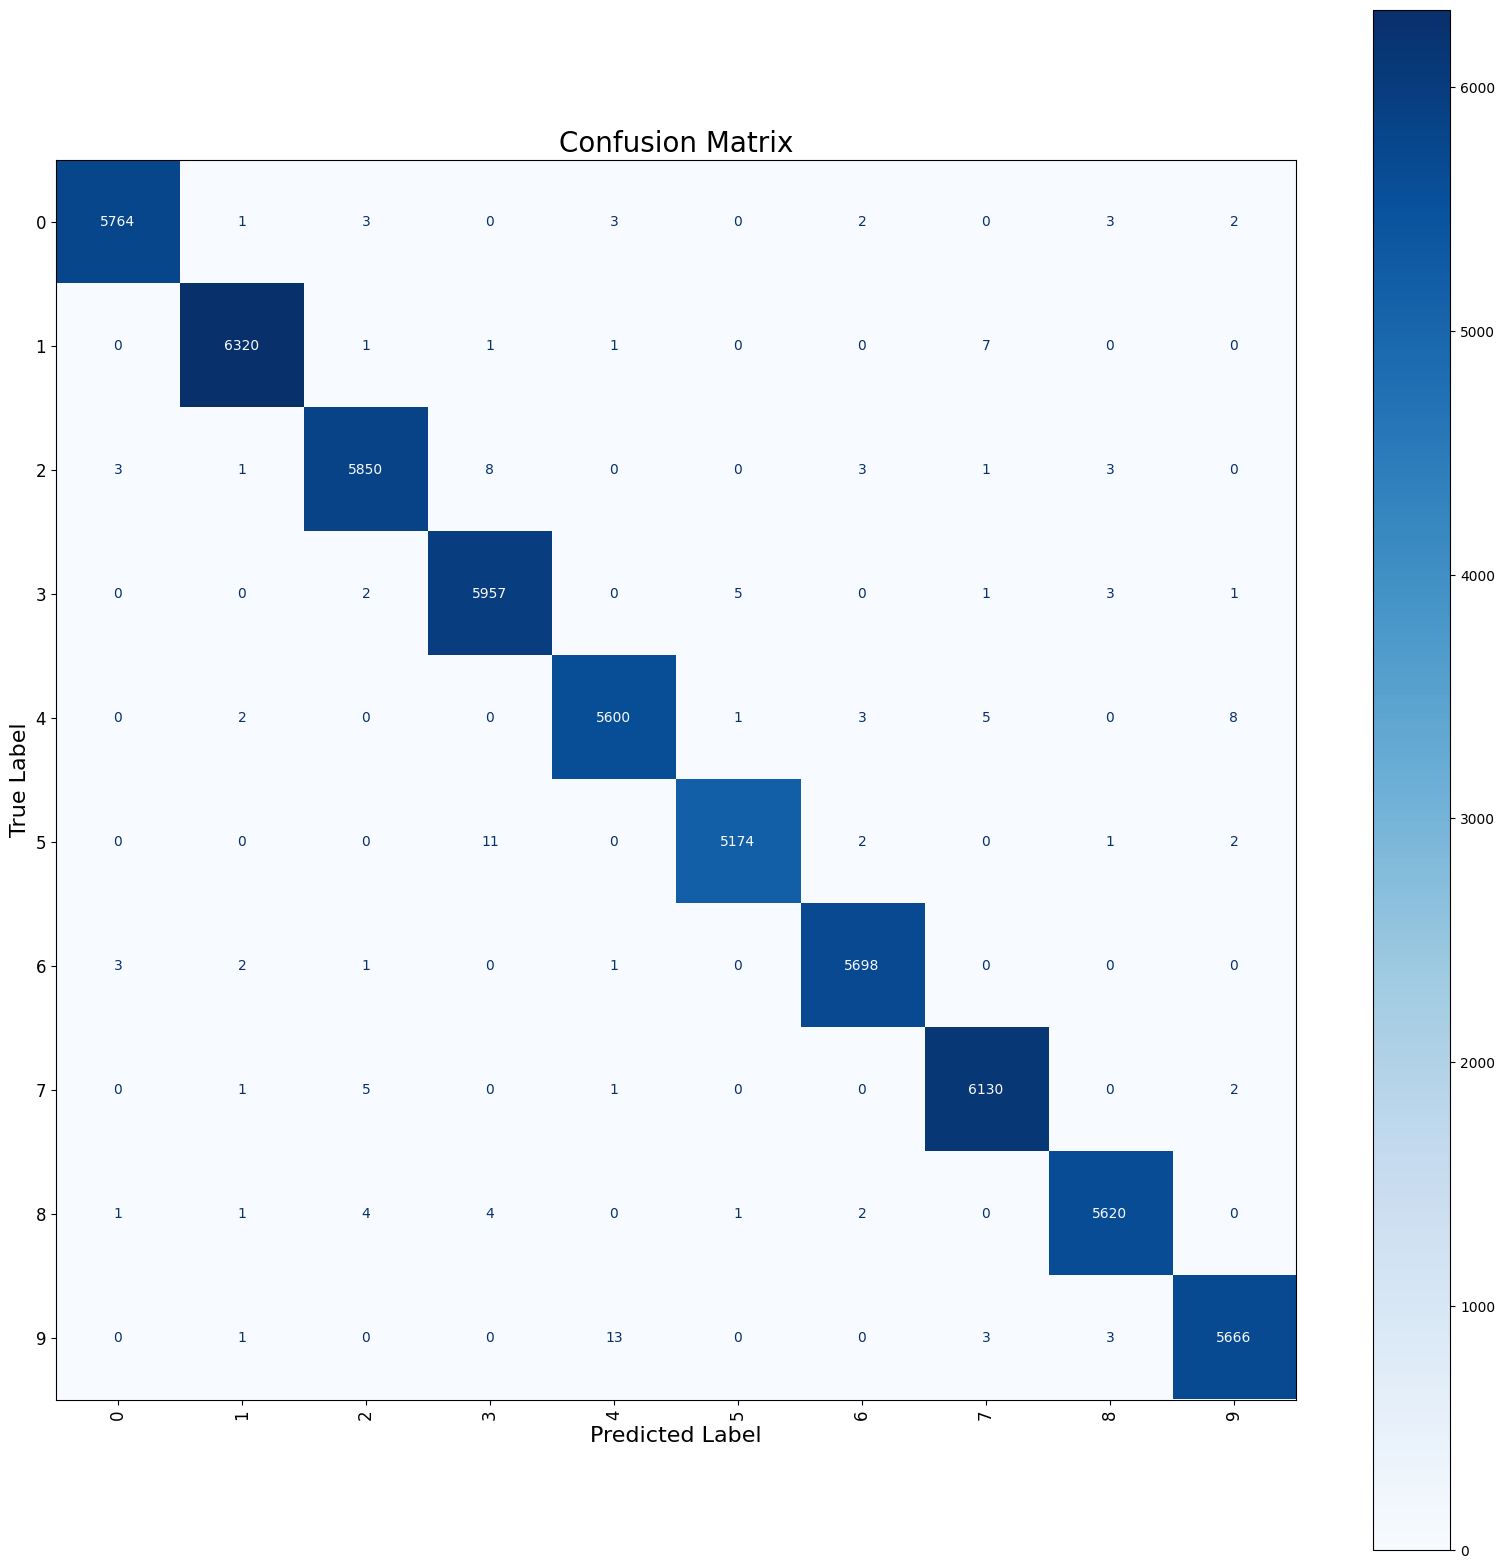

In [16]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Predict labels
y_pred_probs = model.predict(test_generator)
y_pred = np.argmax(y_pred_probs, axis=1)
y_true = test_generator.classes

# Confusion Matrix
cm = confusion_matrix(y_true, y_pred)
labels = list(test_generator.class_indices.keys())

# Create large figure
fig, ax = plt.subplots(figsize=(20, 20))  # Adjust size as needed

# Display Confusion Matrix with custom axis
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
disp.plot(cmap='Blues', ax=ax, xticks_rotation=90)

# Improve font sizes for visibility
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.title("Confusion Matrix", fontsize=20)
plt.xlabel("Predicted Label", fontsize=16)
plt.ylabel("True Label", fontsize=16)
plt.grid(False)

plt.show()


905/905 ━━━━━━━━━━━━━━━━━━━━ 11s 12ms/step


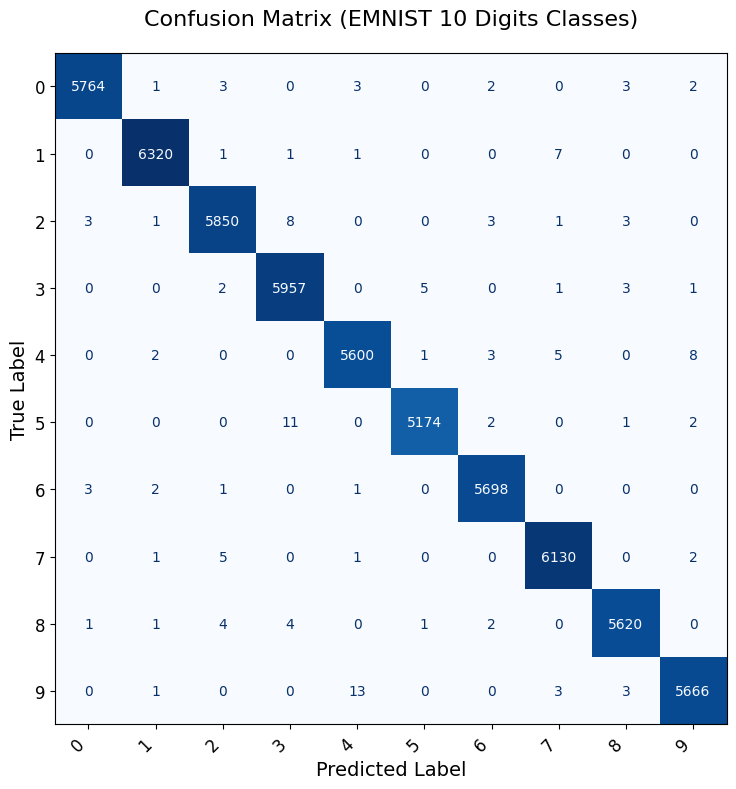

In [18]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Predict labels
y_pred_probs = model.predict(test_generator)
y_pred = np.argmax(y_pred_probs, axis=1)
y_true = test_generator.classes

# Confusion Matrix
cm = confusion_matrix(y_true, y_pred)
labels = list(test_generator.class_indices.keys())  # Should have 10 class names

# Create a smaller, clearer figure
fig, ax = plt.subplots(figsize=(10, 8))  # Adjust for 10 classes

# Display Confusion Matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
disp.plot(cmap='Blues', ax=ax, xticks_rotation=45, colorbar=False)

# Improve readability
plt.xticks(fontsize=12, ha='right')
plt.yticks(fontsize=12)
plt.title("Confusion Matrix (EMNIST 10 Digits Classes)", fontsize=16, pad=20)
plt.xlabel("Predicted Label", fontsize=14)
plt.ylabel("True Label", fontsize=14)
plt.grid(False)

plt.tight_layout()
plt.show()


In [19]:
from sklearn.metrics import classification_report, precision_score, recall_score, f1_score

# Predict and true labels (already obtained previously)
y_pred_probs = model.predict(test_generator)
y_pred = np.argmax(y_pred_probs, axis=1)
y_true = test_generator.classes
class_names = list(test_generator.class_indices.keys())

# Print classification report
report = classification_report(y_true, y_pred, target_names=class_names, digits=4)
print("📋 Classification Report:\n")
print(report)

# Extract and print macro, weighted scores
precision_macro = precision_score(y_true, y_pred, average='macro')
recall_macro = recall_score(y_true, y_pred, average='macro')
f1_macro = f1_score(y_true, y_pred, average='macro')

precision_weighted = precision_score(y_true, y_pred, average='weighted')
recall_weighted = recall_score(y_true, y_pred, average='weighted')
f1_weighted = f1_score(y_true, y_pred, average='weighted')

print("🔢 Macro Scores")
print(f"Precision (Macro): {precision_macro:.4f}")
print(f"Recall (Macro):    {recall_macro:.4f}")
print(f"F1-score (Macro):  {f1_macro:.4f}")

print("\n🔢 Weighted Scores")
print(f"Precision (Weighted): {precision_weighted:.4f}")
print(f"Recall (Weighted):    {recall_weighted:.4f}")
print(f"F1-score (Weighted):  {f1_weighted:.4f}")

905/905 ━━━━━━━━━━━━━━━━━━━━ 10s 12ms/step
📋 Classification Report:

              precision    recall  f1-score   support

           0     0.9988    0.9976    0.9982      5778
           1     0.9986    0.9984    0.9985      6330
           2     0.9973    0.9968    0.9970      5869
           3     0.9960    0.9980    0.9970      5969
           4     0.9966    0.9966    0.9966      5619
           5     0.9986    0.9969    0.9978      5190
           6     0.9979    0.9988    0.9983      5705
           7     0.9972    0.9985    0.9979      6139
           8     0.9977    0.9977    0.9977      5633
           9     0.9974    0.9965    0.9969      5686

    accuracy                         0.9976     57918
   macro avg     0.9976    0.9976    0.9976     57918
weighted avg     0.9976    0.9976    0.9976     57918

🔢 Macro Scores
Precision (Macro): 0.9976
Recall (Macro):    0.9976
F1-score (Macro):  0.9976

🔢 Weighted Scores
Precision (Weighted): 0.9976
Recall (Weighted):    0.9976
F1

In [20]:
import numpy as np
import pandas as pd
from sklearn.metrics import (
    classification_report, precision_score, recall_score, f1_score, accuracy_score
)

# Predict on test data
y_pred_probs = model.predict(test_generator)
y_pred = np.argmax(y_pred_probs, axis=1)
y_true = test_generator.classes

# Define class labels for EMNIST digits (0-9)
class_names = [str(i) for i in range(10)]

# Generate classification report as a dictionary
report_dict = classification_report(y_true, y_pred, target_names=class_names, output_dict=True)
report_df = pd.DataFrame(report_dict).transpose()

# Add additional metrics
accuracy = accuracy_score(y_true, y_pred)
report_df.loc['accuracy'] = [accuracy, None, None, sum(report_df.loc[class_names]['support'])]

# Save classification report as CSV
report_df.to_csv("emnist_classification_report.csv", float_format="%.4f")
print("📄 Classification report saved to 'emnist_classification_report.csv'")

# Print essential metrics
print("📋 Summary of Evaluation Metrics:")
print(f"Accuracy:              {accuracy:.4f}")
print(f"Precision (Macro):     {precision_score(y_true, y_pred, average='macro'):.4f}")
print(f"Recall (Macro):        {recall_score(y_true, y_pred, average='macro'):.4f}")
print(f"F1-score (Macro):      {f1_score(y_true, y_pred, average='macro'):.4f}")
print(f"Precision (Weighted):  {precision_score(y_true, y_pred, average='weighted'):.4f}")
print(f"Recall (Weighted):     {recall_score(y_true, y_pred, average='weighted'):.4f}")
print(f"F1-score (Weighted):   {f1_score(y_true, y_pred, average='weighted'):.4f}")


905/905 ━━━━━━━━━━━━━━━━━━━━ 11s 12ms/step
📄 Classification report saved to 'emnist_classification_report.csv'
📋 Summary of Evaluation Metrics:
Accuracy:              0.9976
Precision (Macro):     0.9976
Recall (Macro):        0.9976
F1-score (Macro):      0.9976
Precision (Weighted):  0.9976
Recall (Weighted):     0.9976
F1-score (Weighted):   0.9976


In [21]:
import numpy as np
import pandas as pd
from sklearn.metrics import (
    classification_report, precision_score, recall_score, f1_score, accuracy_score
)

# Predict on test data
y_pred_probs = model.predict(test_generator)
y_pred = np.argmax(y_pred_probs, axis=1)
y_true = test_generator.classes

# EMNIST digits: class names as strings
class_names = [str(i) for i in range(10)]

# === 1. Full classification report as DataFrame ===
report_dict = classification_report(
    y_true, y_pred, target_names=class_names, output_dict=True, digits=4
)
report_df = pd.DataFrame(report_dict).transpose()

# === 2. Add global metrics explicitly ===
accuracy = accuracy_score(y_true, y_pred)
report_df.loc['accuracy'] = [accuracy, None, None, len(y_true)]

# === 3. Save detailed CSV ===
report_df.to_csv("emnist_classification_report_full.csv", float_format="%.4f")
print("✅ CSV report saved to 'emnist_classification_report_full.csv'")

# === 4. Save readable summary to TXT ===
with open("emnist_classification_summary.txt", "w") as f:
    f.write("📋 EMNIST Classification Summary Report\n")
    f.write("=======================================\n\n")
    f.write(f"🔢 Total Samples: {len(y_true)}\n\n")
    f.write(f"🎯 Accuracy:             {accuracy:.4f}\n")
    f.write(f"📊 Precision (Macro):    {precision_score(y_true, y_pred, average='macro'):.4f}\n")
    f.write(f"📊 Recall (Macro):       {recall_score(y_true, y_pred, average='macro'):.4f}\n")
    f.write(f"📊 F1-score (Macro):     {f1_score(y_true, y_pred, average='macro'):.4f}\n\n")
    f.write(f"⚖️ Precision (Weighted): {precision_score(y_true, y_pred, average='weighted'):.4f}\n")
    f.write(f"⚖️ Recall (Weighted):    {recall_score(y_true, y_pred, average='weighted'):.4f}\n")
    f.write(f"⚖️ F1-score (Weighted):  {f1_score(y_true, y_pred, average='weighted'):.4f}\n\n")
    f.write("📂 Per-Class Metrics:\n")
    f.write(report_df.to_string())
print("✅ Human-readable summary saved to 'emnist_classification_summary.txt'")


905/905 ━━━━━━━━━━━━━━━━━━━━ 11s 12ms/step
✅ CSV report saved to 'emnist_classification_report_full.csv'
✅ Human-readable summary saved to 'emnist_classification_summary.txt'


/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1458: RuntimeWarning: invalid value encountered in greater
  has_large_values = (abs_vals > 1e6).any()
/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in less
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()
/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in greater
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()


In [22]:
import numpy as np
import pandas as pd
from sklearn.metrics import (
    classification_report, precision_score, recall_score, f1_score, accuracy_score
)

# Get predictions and ground truths
y_pred_probs = model.predict(test_generator)
y_pred = np.argmax(y_pred_probs, axis=1)
y_true = test_generator.classes
class_names = [str(i) for i in range(10)]  # EMNIST digits: class names

# Generate classification report dictionary
report_dict = classification_report(
    y_true, y_pred, target_names=class_names, output_dict=True, digits=4
)

# Convert to DataFrame for display
report_df = pd.DataFrame(report_dict).transpose()

# Add overall accuracy
accuracy = accuracy_score(y_true, y_pred)
report_df.loc['accuracy'] = [accuracy, None, None, len(y_true)]

# Display per-class metrics
print("📋 Per-Class Precision, Recall, F1-Score:\n")
display(report_df.loc[class_names])  # Show only class rows

# Display overall scores
print("\n📊 Global Metrics:")
print(f"✅ Accuracy:             {accuracy:.4f}")
print(f"🔁 Precision (Macro):    {precision_score(y_true, y_pred, average='macro'):.4f}")
print(f"🔁 Recall (Macro):       {recall_score(y_true, y_pred, average='macro'):.4f}")
print(f"🔁 F1-Score (Macro):     {f1_score(y_true, y_pred, average='macro'):.4f}")

print(f"⚖️ Precision (Weighted): {precision_score(y_true, y_pred, average='weighted'):.4f}")
print(f"⚖️ Recall (Weighted):    {recall_score(y_true, y_pred, average='weighted'):.4f}")
print(f"⚖️ F1-Score (Weighted):  {f1_score(y_true, y_pred, average='weighted'):.4f}")

print(f"📉 Precision (Micro):    {precision_score(y_true, y_pred, average='micro'):.4f}")
print(f"📉 Recall (Micro):       {recall_score(y_true, y_pred, average='micro'):.4f}")
print(f"📉 F1-Score (Micro):     {f1_score(y_true, y_pred, average='micro'):.4f}")


905/905 ━━━━━━━━━━━━━━━━━━━━ 10s 12ms/step
📋 Per-Class Precision, Recall, F1-Score:



,precision,recall,f1-score,support
0,0.998787,0.997577,0.998182,5778.0
1,0.998578,0.998420,0.998499,6330.0
2,0.997272,0.996763,0.997017,5869.0
3,0.995987,0.997990,0.996987,5969.0
4,0.996619,0.996619,0.996619,5619.0
5,0.998649,0.996917,0.997782,5190.0
6,0.997898,0.998773,0.998336,5705.0
7,0.997234,0.998534,0.997884,6139.0
8,0.997692,0.997692,0.997692,5633.0
9,0.997360,0.996483,0.996921,5686.0



📊 Global Metrics:
✅ Accuracy:             0.9976
🔁 Precision (Macro):    0.9976
🔁 Recall (Macro):       0.9976
🔁 F1-Score (Macro):     0.9976
⚖️ Precision (Weighted): 0.9976
⚖️ Recall (Weighted):    0.9976
⚖️ F1-Score (Weighted):  0.9976
📉 Precision (Micro):    0.9976
📉 Recall (Micro):       0.9976
📉 F1-Score (Micro):     0.9976


In [23]:
import numpy as np
from sklearn.metrics import confusion_matrix

# Predictions & ground truths (you already have these)
y_pred_probs = model.predict(test_generator)
y_pred = np.argmax(y_pred_probs, axis=1)
y_true = test_generator.classes
class_names = [str(i) for i in range(10)]  # adjust for your classes

# Confusion Matrix
cm = confusion_matrix(y_true, y_pred)
# cm shape: (num_classes, num_classes)

num_classes = len(class_names)
sensitivities = []
specificities = []
supports = np.sum(cm, axis=1)  # Number of true samples per class

for i in range(num_classes):
    TP = cm[i, i]
    FN = np.sum(cm[i, :]) - TP
    FP = np.sum(cm[:, i]) - TP
    TN = np.sum(cm) - (TP + FP + FN)
    
    sensitivity = TP / (TP + FN) if (TP + FN) > 0 else 0
    specificity = TN / (TN + FP) if (TN + FP) > 0 else 0
    
    sensitivities.append(sensitivity)
    specificities.append(specificity)

# Weighted sensitivity and specificity per class = metric * support
weighted_sensitivities = sensitivities * supports
weighted_specificities = specificities * supports

# Print results nicely
print(f"{'Class':>5} | {'Support':>7} | {'Sensitivity':>12} | {'Weighted Sensitivity':>20} | {'Specificity':>12} | {'Weighted Specificity':>20}")
print("-" * 90)
for i, cls in enumerate(class_names):
    print(f"{cls:>5} | {supports[i]:7} | {sensitivities[i]:12.4f} | {weighted_sensitivities[i]:20.4f} | {specificities[i]:12.4f} | {weighted_specificities[i]:20.4f}")


905/905 ━━━━━━━━━━━━━━━━━━━━ 11s 12ms/step
Class | Support |  Sensitivity | Weighted Sensitivity |  Specificity | Weighted Specificity
------------------------------------------------------------------------------------------
    0 |    5778 |       0.9976 |            5764.0000 |       0.9999 |            5777.2243
    1 |    6330 |       0.9984 |            6320.0000 |       0.9998 |            6328.8957
    2 |    5869 |       0.9968 |            5850.0000 |       0.9997 |            5867.1959
    3 |    5969 |       0.9980 |            5957.0000 |       0.9995 |            5966.2424
    4 |    5619 |       0.9966 |            5600.0000 |       0.9996 |            5616.9586
    5 |    5190 |       0.9969 |            5174.0000 |       0.9999 |            5189.3110
    6 |    5705 |       0.9988 |            5698.0000 |       0.9998 |            5703.6888
    7 |    6139 |       0.9985 |            6130.0000 |       0.9997 |            6136.9845
    8 |    5633 |       0.9977 |      

905/905 ━━━━━━━━━━━━━━━━━━━━ 11s 12ms/step


/tmp/ipykernel_35/232749541.py:61: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  colors = plt.cm.get_cmap('tab10', num_classes)


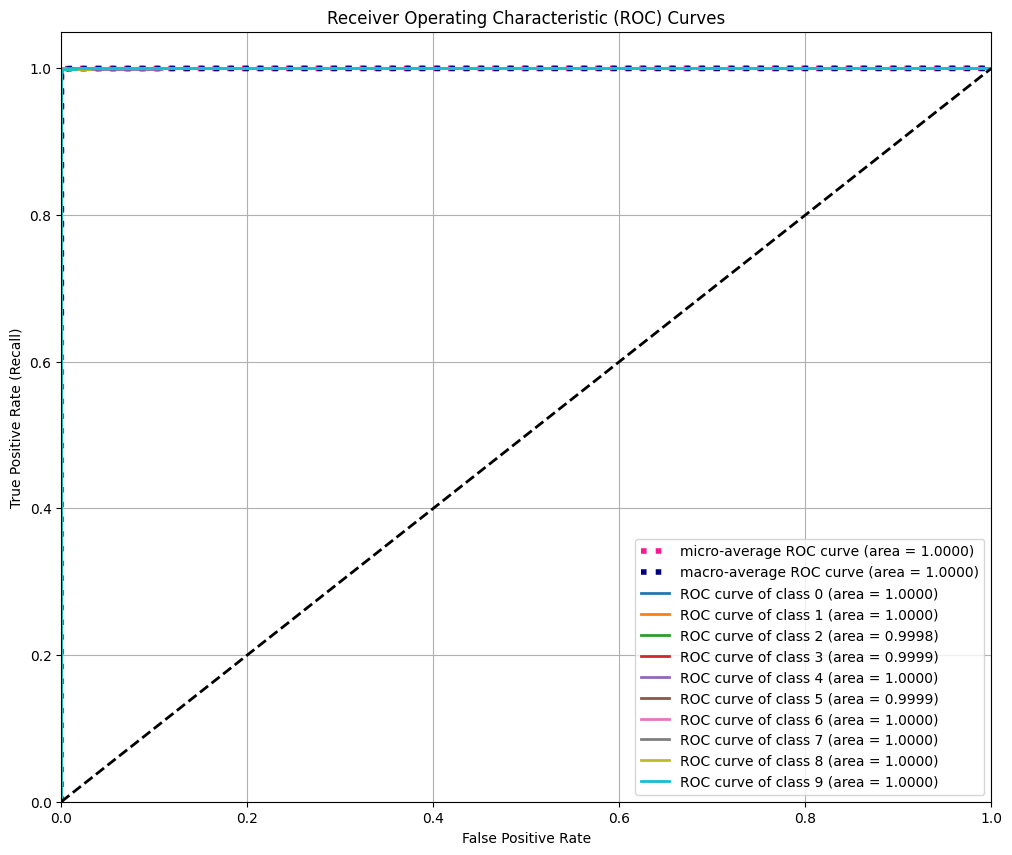

In [24]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize

# Number of classes
num_classes = len(test_generator.class_indices)  # e.g. 10 or 29

# True labels, as integer
y_true = test_generator.classes

# Binarize the output (one-hot encoding for ROC calculation)
y_true_bin = label_binarize(y_true, classes=range(num_classes))

# Predicted probabilities (softmax outputs from your model)
y_pred_probs = model.predict(test_generator)

# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()

for i in range(num_classes):
    fpr[i], tpr[i], _ = roc_curve(y_true_bin[:, i], y_pred_probs[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Compute micro-average ROC curve and ROC area
fpr["micro"], tpr["micro"], _ = roc_curve(y_true_bin.ravel(), y_pred_probs.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

# Compute macro-average ROC curve and ROC area
# Aggregate all false positive rates
all_fpr = np.unique(np.concatenate([fpr[i] for i in range(num_classes)]))

# Then interpolate all ROC curves at these points
mean_tpr = np.zeros_like(all_fpr)
for i in range(num_classes):
    mean_tpr += np.interp(all_fpr, fpr[i], tpr[i])

# Average it and compute AUC
mean_tpr /= num_classes

fpr["macro"] = all_fpr
tpr["macro"] = mean_tpr
roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

# Plot all ROC curves
plt.figure(figsize=(12, 10))

# Plot micro-average ROC
plt.plot(fpr["micro"], tpr["micro"],
         label=f'micro-average ROC curve (area = {roc_auc["micro"]:.4f})',
         color='deeppink', linestyle=':', linewidth=4)

# Plot macro-average ROC
plt.plot(fpr["macro"], tpr["macro"],
         label=f'macro-average ROC curve (area = {roc_auc["macro"]:.4f})',
         color='navy', linestyle=':', linewidth=4)

# Plot ROC for each class
colors = plt.cm.get_cmap('tab10', num_classes)

for i in range(num_classes):
    plt.plot(fpr[i], tpr[i], color=colors(i),
             lw=2, label=f'ROC curve of class {class_names[i]} (area = {roc_auc[i]:.4f})')

plt.plot([0, 1], [0, 1], 'k--', lw=2)  # Diagonal
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate (Recall)')
plt.title('Receiver Operating Characteristic (ROC) Curves')
plt.legend(loc="lower right")
plt.grid(True)
plt.show()


905/905 ━━━━━━━━━━━━━━━━━━━━ 10s 12ms/step


/tmp/ipykernel_35/2077439044.py:55: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  colors = plt.cm.get_cmap('tab20', num_classes)
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128200 (\N{CHART WITH UPWARDS TREND}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


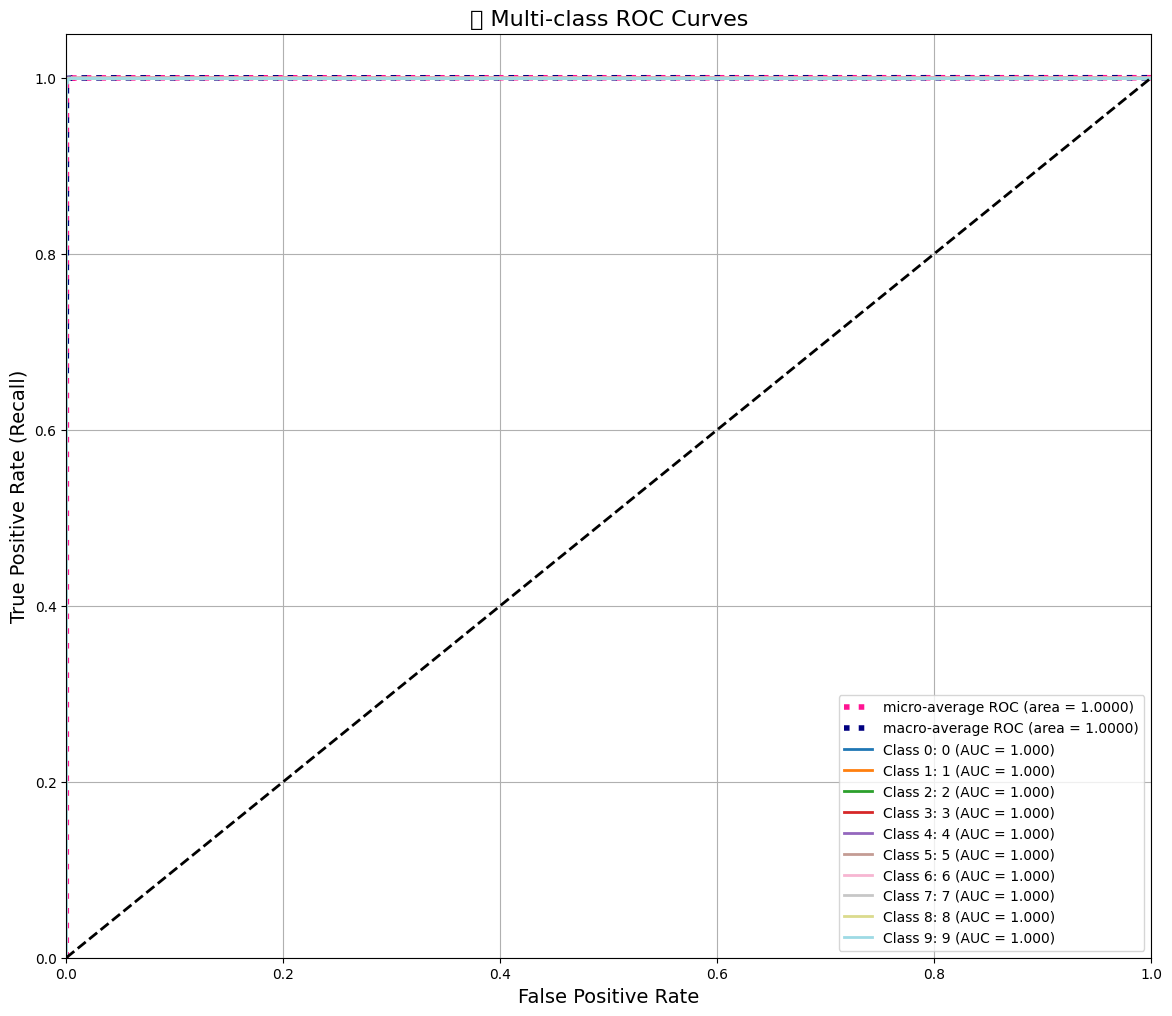

In [25]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize
from tensorflow.keras.utils import to_categorical

# Number of classes
num_classes = len(test_generator.class_indices)
class_names = list(test_generator.class_indices.keys())

# Get true and predicted values
y_true = test_generator.classes                    # shape: [n_samples,]
y_pred_probs = model.predict(test_generator)       # shape: [n_samples, num_classes]

# Binarize y_true to one-hot
y_true_bin = label_binarize(y_true, classes=range(num_classes))

# Compute ROC curve and AUC for each class
fpr = dict()
tpr = dict()
roc_auc = dict()

for i in range(num_classes):
    fpr[i], tpr[i], _ = roc_curve(y_true_bin[:, i], y_pred_probs[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Compute micro-average ROC curve and ROC area
fpr["micro"], tpr["micro"], _ = roc_curve(y_true_bin.ravel(), y_pred_probs.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

# Compute macro-average ROC curve and ROC area
all_fpr = np.unique(np.concatenate([fpr[i] for i in range(num_classes)]))
mean_tpr = np.zeros_like(all_fpr)
for i in range(num_classes):
    mean_tpr += np.interp(all_fpr, fpr[i], tpr[i])
mean_tpr /= num_classes
fpr["macro"] = all_fpr
tpr["macro"] = mean_tpr
roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

# Plot ROC curves
plt.figure(figsize=(14, 12))

# Plot micro-average ROC
plt.plot(fpr["micro"], tpr["micro"],
         label=f"micro-average ROC (area = {roc_auc['micro']:.4f})",
         color='deeppink', linestyle=':', linewidth=4)

# Plot macro-average ROC
plt.plot(fpr["macro"], tpr["macro"],
         label=f"macro-average ROC (area = {roc_auc['macro']:.4f})",
         color='navy', linestyle=':', linewidth=4)

# Plot ROC for each class (limit labels if too many)
colors = plt.cm.get_cmap('tab20', num_classes)
for i in range(num_classes):
    plt.plot(fpr[i], tpr[i], lw=2, color=colors(i),
             label=f"Class {i}: {class_names[i]} (AUC = {roc_auc[i]:.3f})")

plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate', fontsize=14)
plt.ylabel('True Positive Rate (Recall)', fontsize=14)
plt.title('📈 Multi-class ROC Curves', fontsize=16)
plt.legend(loc="lower right", fontsize=10)
plt.grid(True)
plt.show()
